In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Regularisation

Regularisation is a technique used when Network suffer from over-fitting or high variance. This means that the Network is overly complex such that it starts mapping the noises within the data instead of the true function.

Regularisation prevents overfitting as it involves reducing the weights of the Network somehow. By reducing the weights lower, or at times to 0, our Network becomes much 'smaller' as the impacts of some of the neurons in our Network becomes smaller. As such, we get a much simpler Network compared to before. In addition, activation functions, such as Tanh, becomes non-linear as Z approaches large values. By reducing the weights, our overall Z values are smaller as well. This brings the Z values within the linear range of the activation function, and thus, simplifying the Network. By limiting the Network's ability to compute very complex models, it is less likely for it to over-fit to the dataset.

One way to adress overfitting is to simply get more data. However, getting more data is sometimes not possible, expensive or tedious. As such, in this script, we will be focused on regularisation techniques and how they improve the variance of models.

Regularisation Techniques:
1. L1 & L2 Regularisations
    - Introduce a secondary term to the cost function that penalises the weights of the Network.
2. Frobenius norm
3. Dropout
    - by randomly dropping units, the Network cannot rely on any 1 feature; Network is reluctant to put too much weight on any unit and thus squared norm of the weights falls.
4. Data Augmentation (slightly more applicable to Computer Vision problems)
5. Early Stopping
    - through iterations, weights grows larger and larger; by stopping it prematurely, we prevent the weights from growing too large.
    - does not abide by the principle of orthogonalisation

# Generate data

In [2]:
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

In [34]:
# create a classification problem using sklearn dataset
x, y = make_classification(n_samples=10000,
                           n_features=3,
                           n_informative=2,
                           n_redundant=0,
                           n_classes=2,
                           flip_y=0.2,
                           random_state=2020
                          )

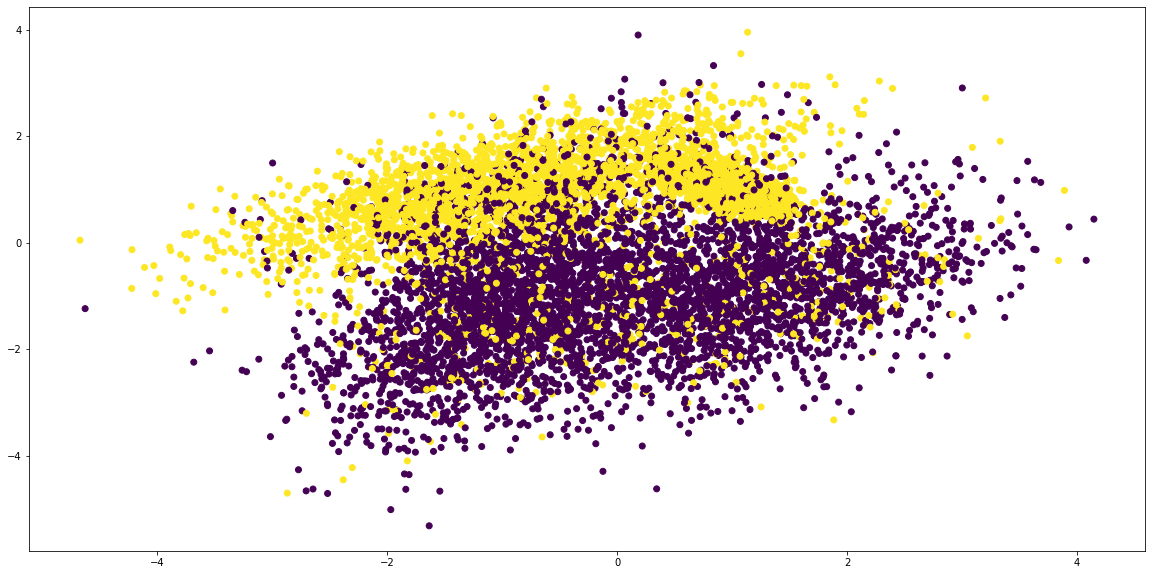

In [35]:
plt.figure(figsize=[20,10])
plt.scatter(x[:,0], x[:,1], c=y)

In [36]:
# transform to tensors
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).long()

In [37]:
# split to train & validation set
split = int(0.9 * 10000)
x_train = x[:split]
x_val = x[split:]
y_train = y[:split]
y_val = y[split:]

# Overfitting

In [38]:
# Network architecture
complex_model = nn.Sequential(
    nn.Linear(3, 256),
    nn.Tanh(),
    nn.Linear(256,512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 2)
)

# move model to gpu
complex_model = complex_model.cuda()

# loss & optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(complex_model.parameters(), lr =0.001)

In [39]:
# Training the Network
epochs = 1000
loss = []
val_loss = []
batch_size = 256

for e in range(epochs):
    
    permutation = torch.randperm(x_train.size()[0]) # random permutation to group batches differently
    
    for i in range(0, x_train.size()[0], batch_size):
        optimiser.zero_grad() # zero out any pre-computed gradients
        
        # assign batch
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

        output = complex_model(batch_x) # forward prop
        run_loss = criterion(output, batch_y) # compute loss
        loss.append(run_loss.item()/batch_x.size()[0]) # store loss
        run_loss.backward() # backprop - calculate gradients
        optimiser.step() # update weights
    
    permutation = torch.randperm(x_val.size()[0]) # random permutation to group batches differently
    
    for i in range(0, x_val.size()[0], batch_size):
        
        # assign batch
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        output = complex_model(batch_x)
        run_loss = criterion(output, batch_y)
        val_loss.append(run_loss.item()/batch_x.size()[0])

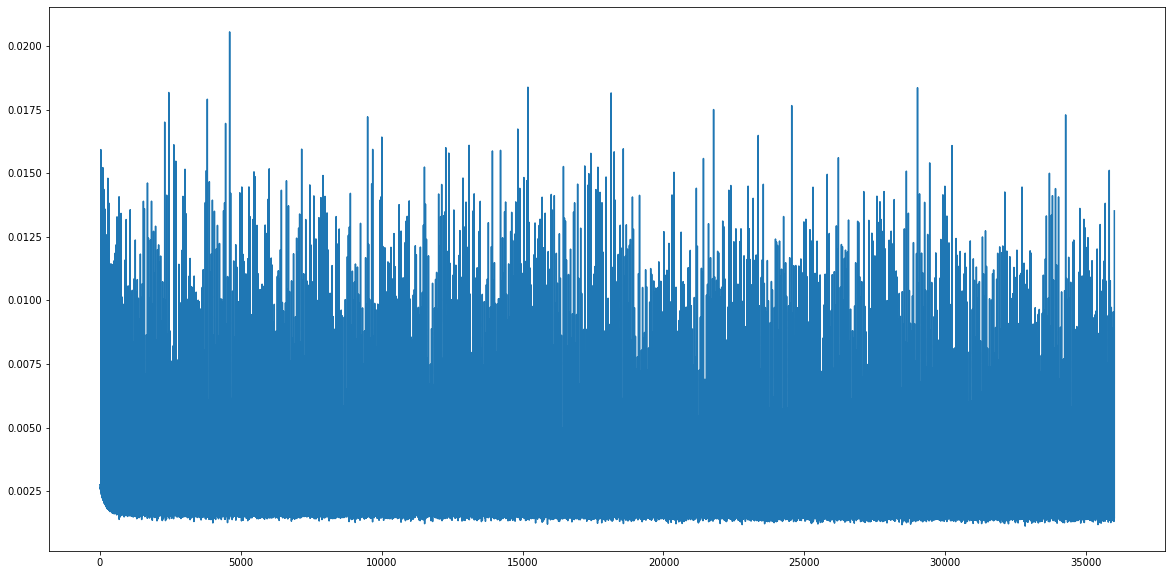

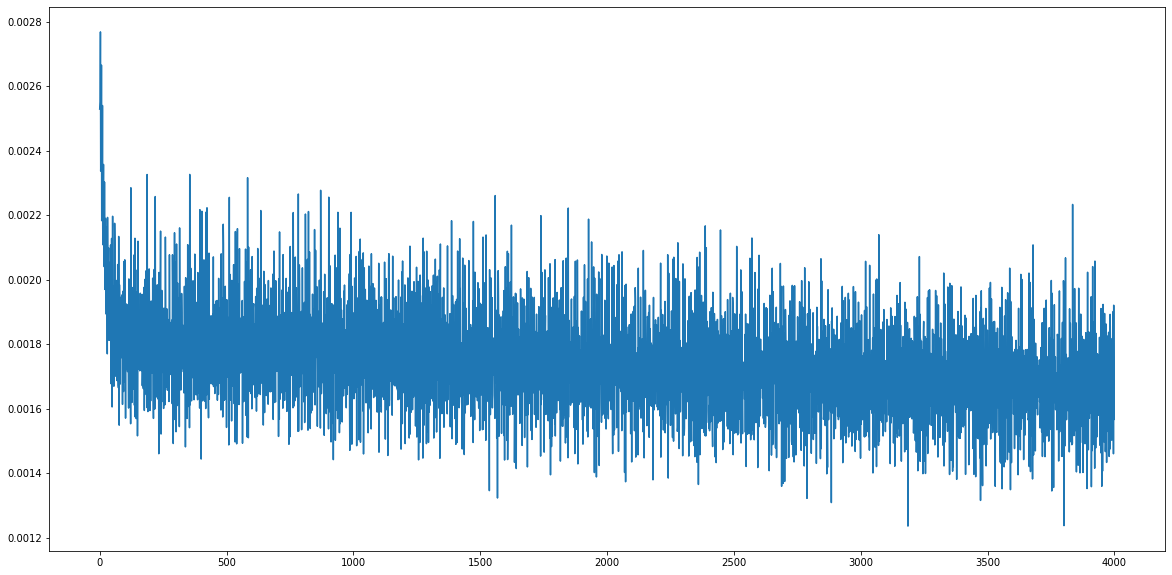

In [40]:
plt.figure(figsize=[20,10])
plt.plot(range(len(loss)), loss)
plt.show()
plt.figure(figsize=[20,10])
plt.plot(range(len(val_loss)), val_loss)
plt.show()

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      4446
           1       0.82      0.88      0.85      4554

    accuracy                           0.84      9000
   macro avg       0.85      0.84      0.84      9000
weighted avg       0.85      0.84      0.84      9000



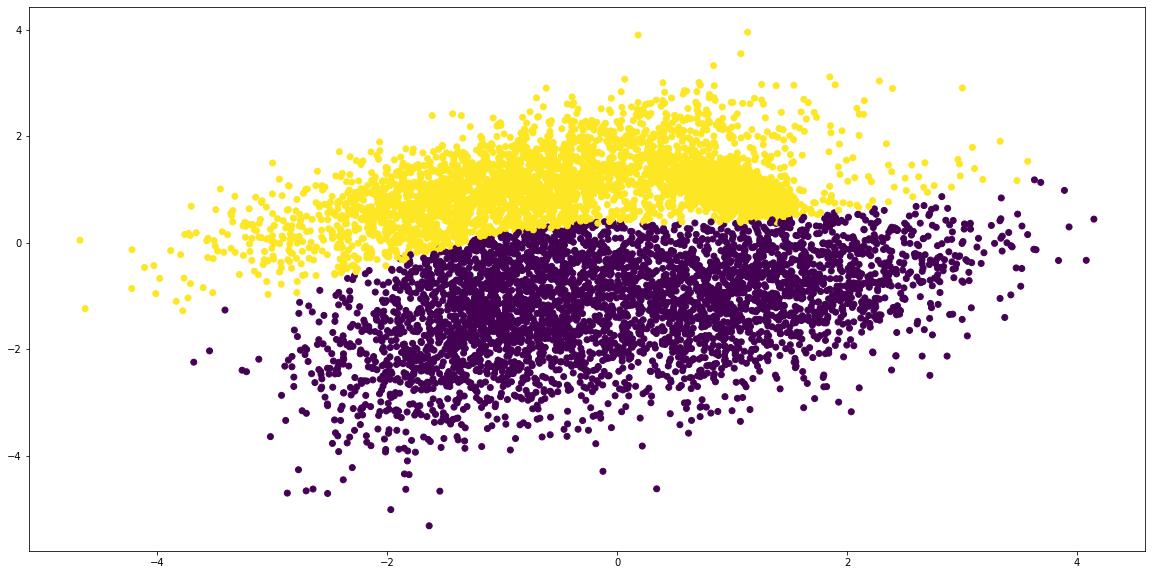

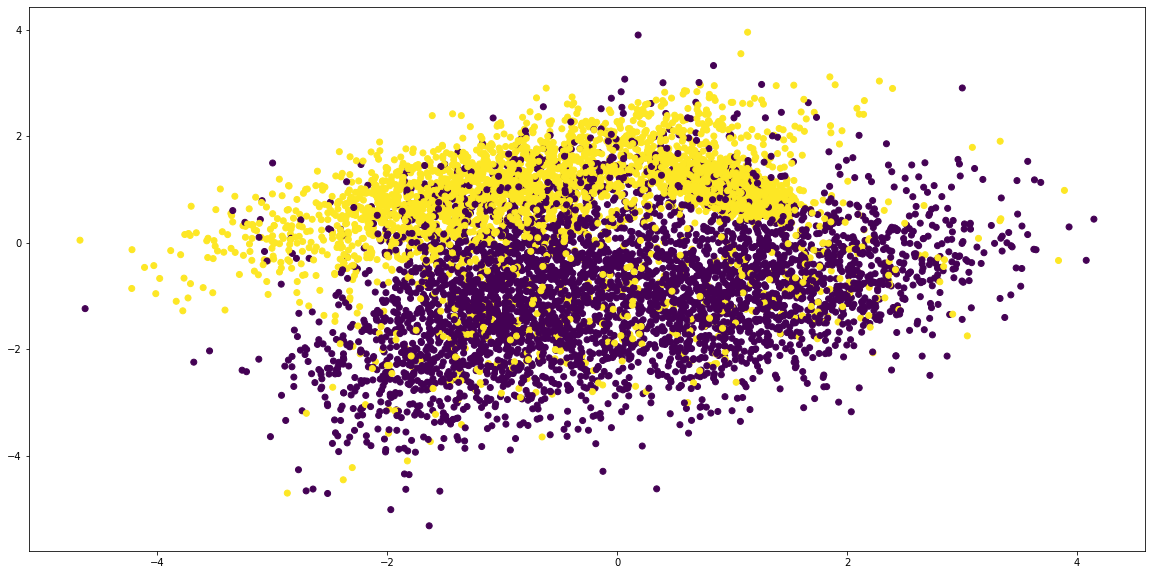

In [41]:
# Training accuracy
complex_model.cpu()
output = complex_model(x_train)
_, predictions = torch.max(output, axis=1)
print(classification_report(y_train, predictions))

# plot predictions
plt.figure(figsize=[20,10])
plt.scatter(x_train[:,0], x_train[:,1], c=predictions)

# plot predictions
plt.figure(figsize=[20,10])
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       505
           1       0.81      0.87      0.84       495

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



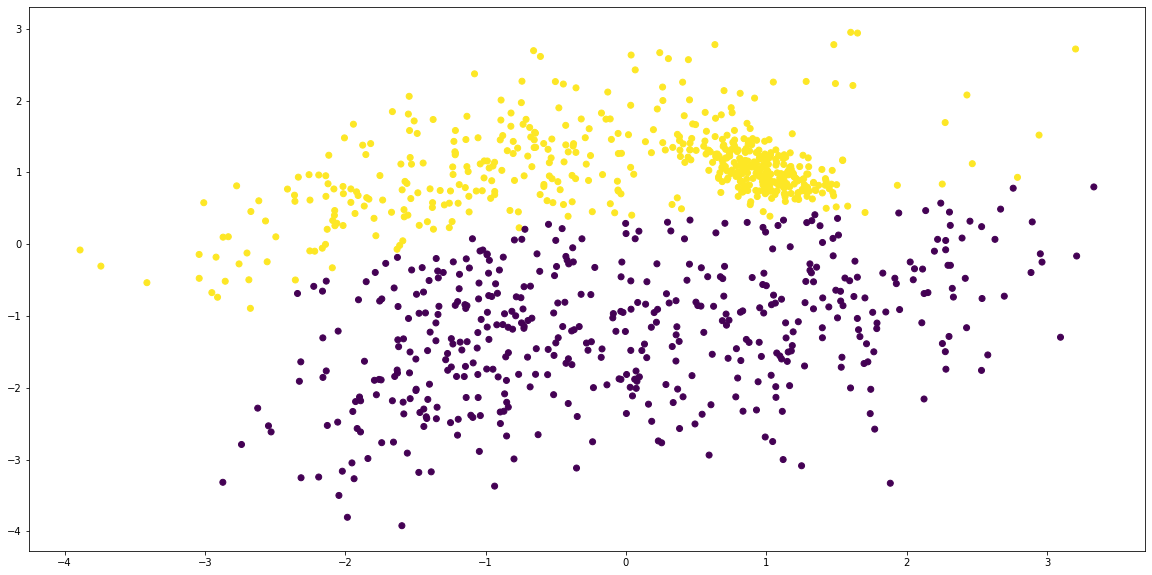

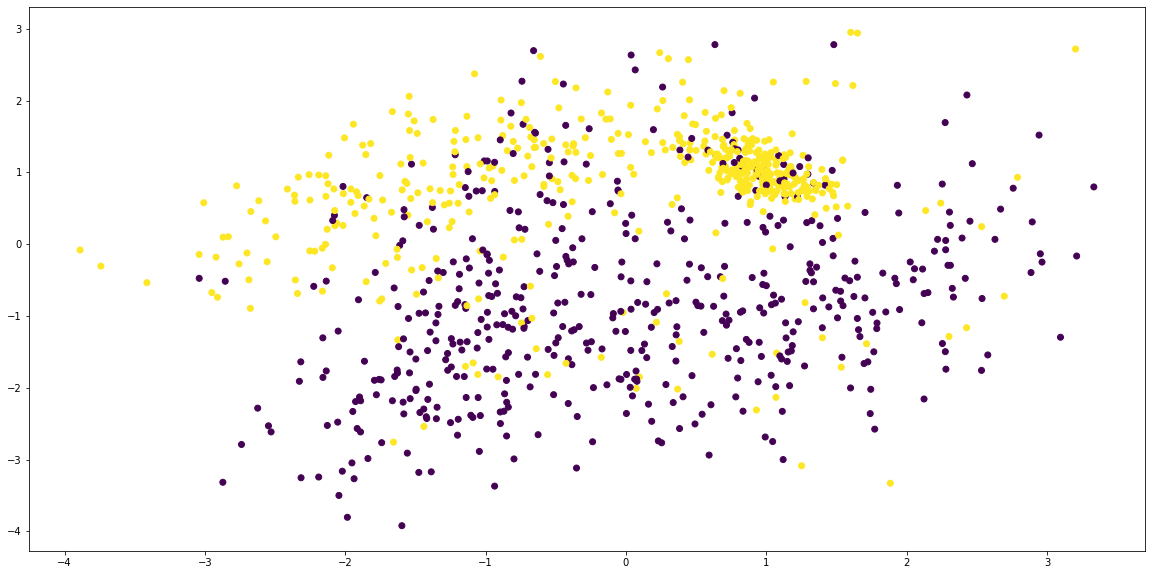

In [42]:
# Val accuracy
output = complex_model(x_val)
_, predictions = torch.max(output, axis=1)
print(classification_report(y_val, predictions))

# plot predictions
plt.figure(figsize=[20,10])
plt.scatter(x_val[:,0], x_val[:,1], c=predictions)

# plot predictions
plt.figure(figsize=[20,10])
plt.scatter(x_val[:,0], x_val[:,1], c=y_val)